# Dense Basis SED fitting 
#### By Tanmoy Bhowmik
#### Mowla Astro Research Group

### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dense_basis as db
import fsps
import corner
import os
import time
import hickle
from tqdm import tqdm
import seaborn as sns
from astropy.io import ascii
from astropy.table import Table
from matplotlib import rc

In [3]:
import dense_basis as db
import fsps
print("DB version: ", db.__version__)
db.mocksp # Just to check if db is working properly

DB version:  0.1.9


### Define Object ID no. and Cluster No.

In [4]:
idno = "sparkler"
cluster_name = "linux"

### Other Inputs

In [5]:
redshift, redshift_width = 1.3775, 1.385

In [6]:
eazy_z = 1.35         
eazy_zw = 0.1

In [7]:
FILTS = [
    "F090W",
    "F150W",
    "F200W",
    "F277W",
    "F356W",
    "F444W"
]

# Corresponding effective wavelengths (in microns)
WAVES = [0.90, 1.50, 2.00, 2.77, 3.56, 4.44]


## Prerequisites to fitting: 

If you’re fitting photometry, put your photometric filter transmission curves in a folder somewhere and make a list of filter curves with the paths to each filter. You’ll need to pass `filter_list` and `filt_dir` as arguments to the code to generate SEDs corresponding to a given parameter set. 

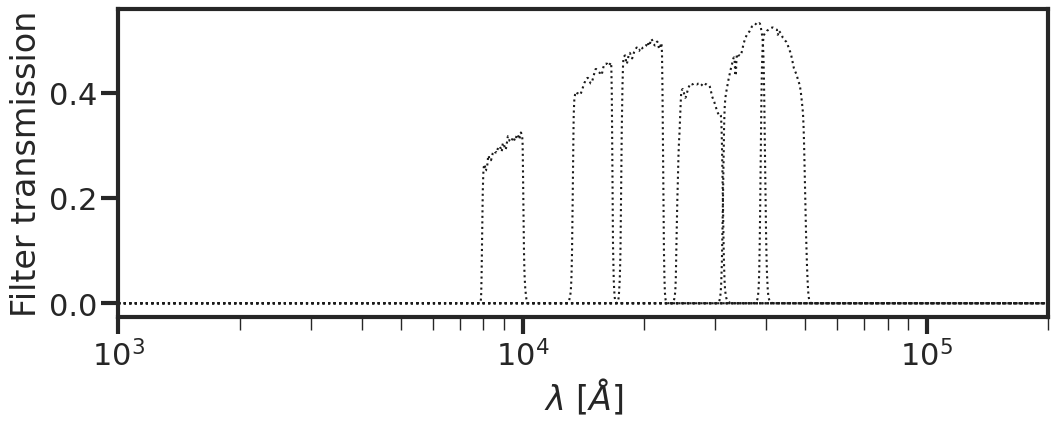

In [8]:
filter_list_file = "filter_list_sparkler.txt"
filt_dir = "filters/"
db.plot_filterset(filter_list = filter_list_file, filt_dir = filt_dir)

In [9]:
import os

filt_dir = "filters/"
available = os.listdir(filt_dir)
print("Files found in 'filters/':\n", available)


Files found in 'filters/':
 ['.ipynb_checkpoints', 'jwst_nircam_f150w.txt', 'filter_list_sparkler.txt', 'jwst_nircam_f277w.txt', 'jwst_nircam_f356w.txt', 'jwst_nircam_f444w.txt', 'jwst_nircam_f200w.txt', 'New folder', 'jwst_nircam_f090w.txt']


In [10]:
# filter_names = filt_names
lam_centers = []
lam_widths = []

lam = np.linspace(1e3,1e6,int(1e5))
z = 0.0
vb = False

fcurves = db.make_filvalkit_simple(lam,z, fkit_name = filter_list_file ,vb=False, filt_dir = filt_dir)

for i in range(fcurves[0].shape[1]):

    normed_fc = np.cumsum(fcurves[0].T[i])/np.amax(np.cumsum(fcurves[0].T[i]))
    lam_eff = fcurves[1][np.argmin(np.abs(normed_fc-0.5))]
    lam_width_lo = fcurves[1][np.argmin(np.abs(normed_fc-0.025))]
    lam_width_hi = fcurves[1][np.argmin(np.abs(normed_fc-0.975))]
    lam_width = lam_width_hi - lam_width_lo

    lam_centers.append(lam_eff)
    lam_widths.append(lam_width)
    if vb == True:
        print(lam_eff, lam_width)
        print(filter_names[i])
        plt.plot(fcurves[1], normed_fc)
        plt.xscale('log')
        plt.show()
        
lam_centers = np.array(lam_centers)
print(lam_centers)
lam_widths = np.array(lam_widths)

[ 9052.02052021 15056.07056071 19941.22941229 27673.56673567
 35855.45855459 44017.3701737 ]


### 1. Instantiate a Priors() object

The next step is to generate a template atlas that you will use for fitting. The advantage of doing this is that we trade time-complexity for space, which is usually much more abundant, and it only needs to be done once to fit a large dataset. Before doing this, however, we need a set of priors that we can draw from to generate this atlas. This is done using the `db.Priors()` class:

### Priors Setup

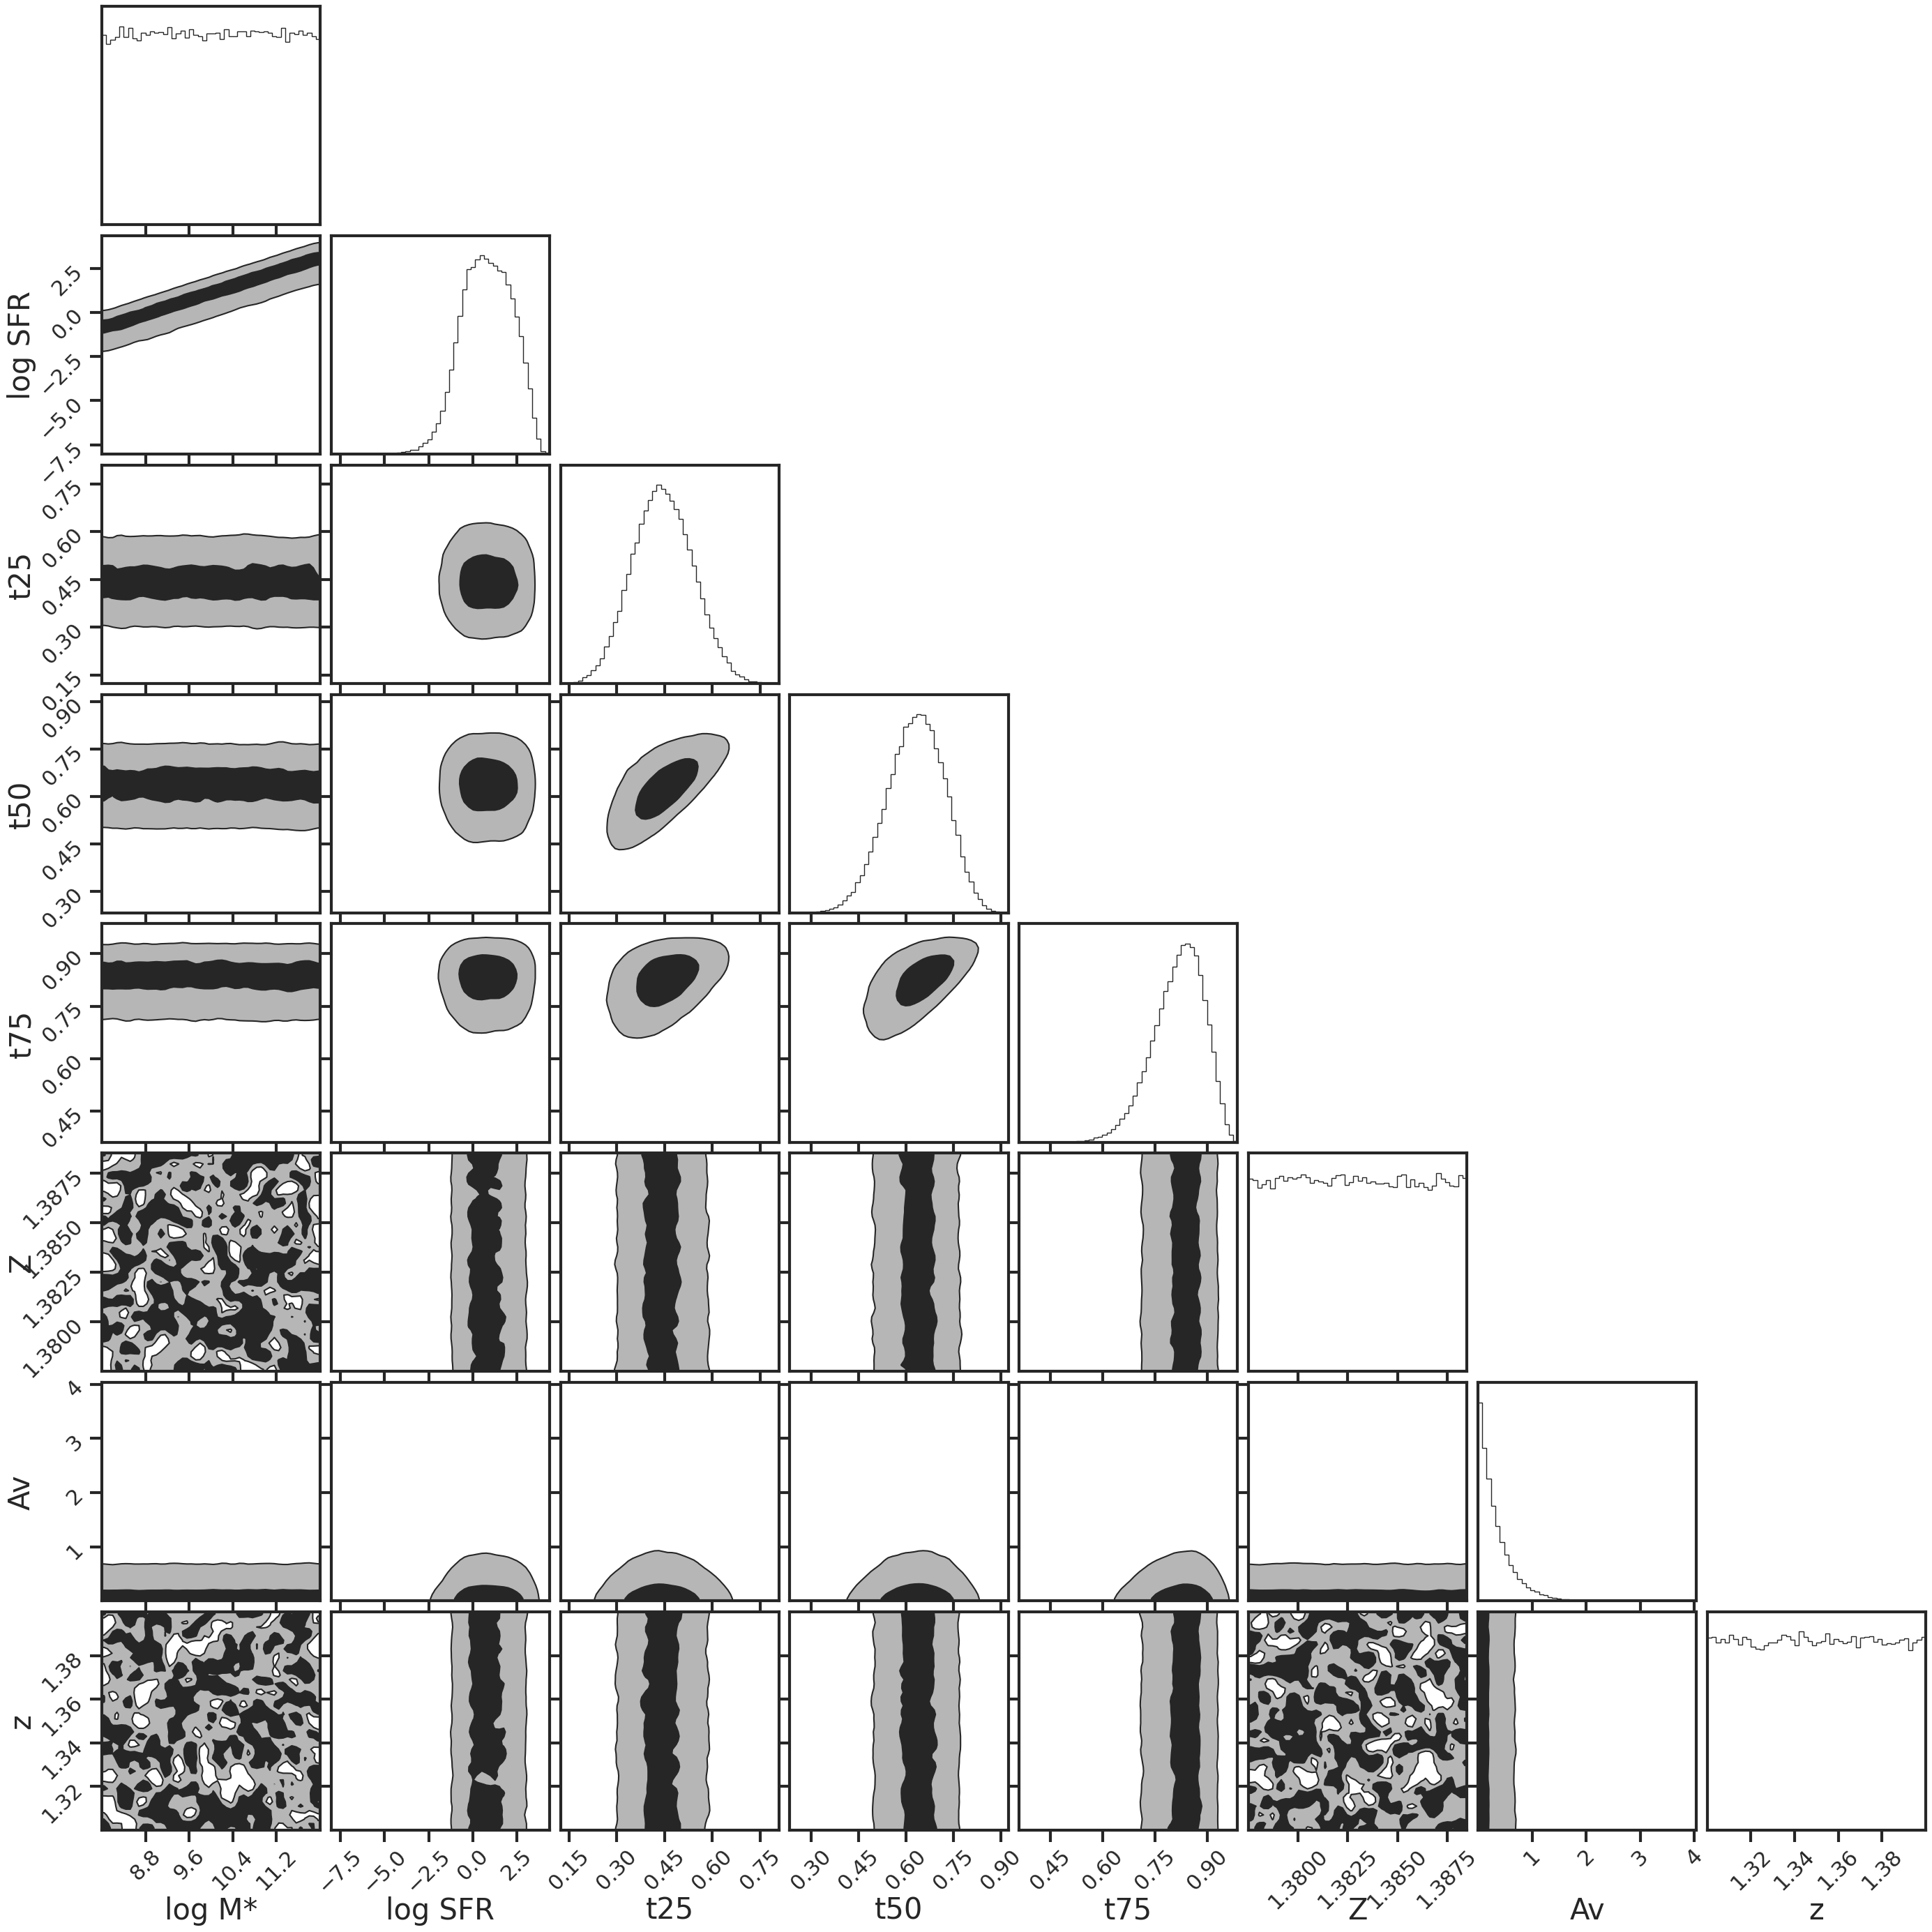

In [11]:
# Priors class, to see all the options look in the priors.py file in the dense_basis folder
priors = db.Priors()
priors.mass_min = 8
priors.mass_max = 12.0

# SFH priors
priors.Nparam = 3
priors.tx_alpha = np.ones((priors.Nparam + 1,)) * 5.0
priors.tx_alpha[0] = 12.0

# SFR prior
priors.sfr_prior_type = "sSFRlognormal"
priors.ssfr_max = -8.
priors.ssfr_min = -12.5
priors.dynamic_decouple = True

# metallicity prior
priors.met_treatment = "flat"
priors.Z_min = 1.3775
priors.Z_max = 1.3885

# dust prior
priors.dust_prior = "exp"
# priors.Av_exp_scale = 1.0
priors.Av_min = 0
priors.Av_max = 3

# redshift prior
priors.z_min = 1.3
priors.z_max = 1.4
# This will now plot the correct distributions
priors.plot_prior_distributions()


### 2. Generate an atlas of parameters drawn from the prior and their corresponding SEDs.

Now we can use the priors object to generate the atlas. The important arguments here are the size of the atlas (`N_pregrid`), which samples from the overall multidimensional prior distributions, and the number of SFH parameters (`priors.Nparam`). The generated atlas is then stored in a local `/pregrids` folder with the user-specified fname within the current working directory. Please specify a different path using the `path` argument if you would like it to be stored in a different place. The first few SEDs take time to compute because every time FSPS encounters a new metallicity value it needs to load a grid into memory. This happens only once, and when it is done, the atlas generation process speeds up considerably.

In [15]:
fname = "sparkler_atlas"
N_pregrid = 50000
path = "pregrids/"

# Generate atlas if not exists
atlas_file = os.path.join(path, f"{fname}_N{N_pregrid}_P{priors.Nparam}.npz")

#if not os.path.exists(atlas_file):
db.generate_atlas(
        N_pregrid=N_pregrid,
        priors=priors,
        fname=fname,
        store=True,
       filter_list=filter_list_file,
        filt_dir=filt_dir,
    )


generating atlas with: 
3  tx parameters,  sSFRlognormal  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.



00%|███████████████████████████████████████████████████████████████████| 50000/50000 [40:14<00:00, 20.71it/s]

Path exists. Saved atlas at : pregrids/sparkler_atlas_50000_Nparam_3.dbatlas


### 4. Load the previously generated atlas:

In [12]:
fname = "sparkler_atlas"
N_pregrid = 50000
path = "pregrids/"
atlas = db.load_atlas(fname, N_pregrid=N_pregrid, N_param=priors.Nparam, path=path)
print("Atlas ready! Keys:", list(atlas.keys()))

Atlas ready! Keys: ['zval', 'sfh_tuple', 'sfh_tuple_rec', 'norm', 'norm_method', 'mstar', 'sfr', 'dust', 'met', 'sed']


### Load Photometry

In [13]:
tphot = ascii.read("sparkler_flux_SED1.csv")
spIDs = tphot["ID"]
tphot

ID,F444W_flux,F444W_fluxerr,F356W_flux,F356W_fluxerr,F277W_flux,F277W_fluxerr,F200W_flux,F200W_fluxerr,F150W_flux,F150W_fluxerr,F090W_flux,F090W_fluxerr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7,63.32430179396205,0.46658081614878205,62.942214607407244,0.35925748387350515,56.78044235,0.3868266803304384,50.23760124921053,0.5545042977940067,41.95191862016095,0.5519756128028894,19.027163654889943,0.32398751742298015
9,57.84203644079474,0.46616556283776717,58.27452161087643,0.3580265580914723,54.653849086057186,0.384132915,51.88685177086928,0.54648507,45.59775947196628,0.5502668620272071,21.329384938001088,0.32003376210489615
12,21.28718062039156,0.47589131720366173,24.003539946271665,0.35822939867394055,24.225445434152178,0.3833517668969861,26.82234299822789,0.5418199835660288,22.888880774067303,0.5545284896062297,12.846958503740998,0.3179913819501918
14,48.48169755467639,0.4720880893491469,50.246921778630764,0.3566678150682771,46.76200898227903,0.3797560068503841,45.51826711214285,0.5334798517659952,38.138755675238194,0.5484633176415599,17.197460767805214,0.31436562936579765
15,27.538588787314715,0.4761971986878213,30.866741207998935,0.3576108102376117,29.200491576155805,0.38243716214850904,32.79170731256996,0.539269024,29.184921734529347,0.5529021054927319,15.476608628301044,0.3166482128110035
16,50.187749020000965,0.46692195805445225,53.06777189945312,0.3562364403064031,49.19150410699717,0.3798830864925904,48.502094068156936,0.5338149163002844,38.21841592894379,0.5512327157387895,18.467958032344693,0.3126130856739442
18,44.90970393601539,0.4673738652902412,46.30283381636001,0.3557040141503773,43.874847275317705,0.3775756159032339,40.846630537975145,0.5286277333810084,36.25492108940976,0.5446115777461855,15.023601522579066,0.31228000511485043
22,11.881159887907877,0.4611212890625478,12.52878023937063,0.35242858630005647,15.917281427634952,0.3739669596669269,15.56029596385617,0.5146852393933392,15.252788653825194,0.5351830670543163,7.574074469384305,0.30601875021545577
23,38.491,0.473,34.627,0.357,31.636,0.381,33.312,0.535,30.846,0.55,11.45,0.315


### Plot Photometry for All Sources

Text(0, 0.5, 'Flux [nJy]')

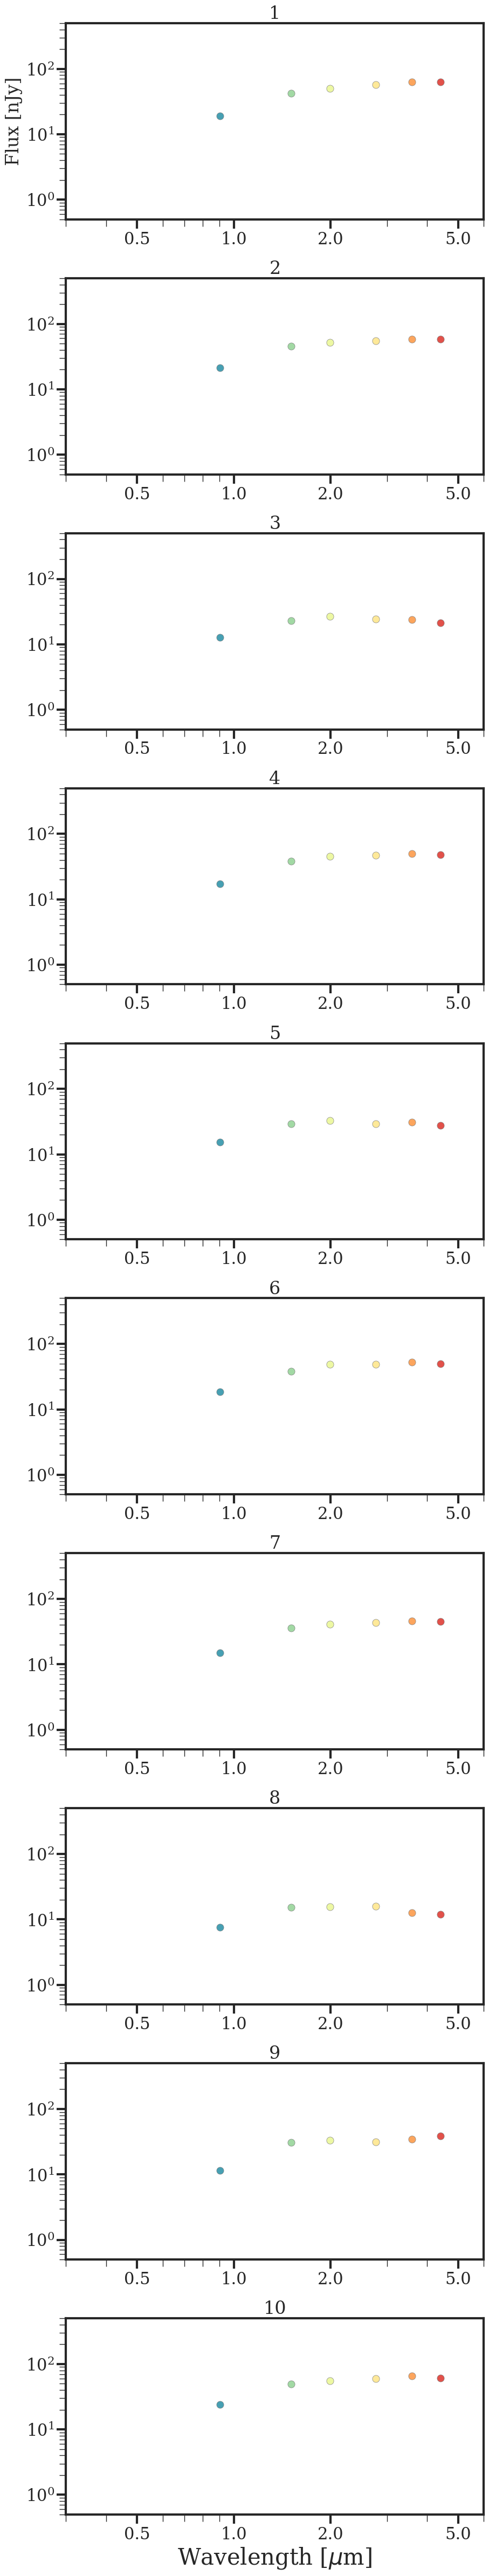

In [14]:
# Set global font settings for plots
font = {"family": "serif", "size": 8}
rc("font", **font)

# Create a color palette based on the number of filters
cs = sns.color_palette("Spectral_r", len(FILTS))

# Create one subplot per source in the photometry table
f, axes = plt.subplots(len(spIDs), 1, figsize=(10, 60))  # Big vertical stack of plots
axs = axes.ravel()  # Flatten in case of 1D axes

# Loop through each object in the catalog
for j in range(len(tphot)):
    ax = axs[j]  # Get the corresponding axis for this object

    # Loop through each filter
    for i in range(len(FILTS)):
        # Extract flux and flux error (in nanoJanskys) for this object in this filter
        sed = tphot[j][FILTS[i] + "_flux"]
        err = tphot[j][FILTS[i] + "_fluxerr"]
        # Note: This could be a constant fractional error if actual errors are missing

        # Plot the photometric point with error bars (in grey, behind)
        ax.errorbar(
            lam_centers[i] / 1e4,  # Convert from Å to μm
            sed, 
            yerr=err, 
            marker="o", 
            c="gray", 
            ms=9, 
            zorder=0  # Behind the colored dot
        )

        # Plot the point again in color (on top)
        ax.plot(
            lam_centers[i] / 1e4,
            sed,
            marker="o",
            c=cs[i],
            ms=8,
            zorder=2
        )

    # Set log-log axes: photometry spans orders of magnitude
    ax.set_xscale("log")
    ax.set_yscale("log")

    # Wavelength range from 0.3 to 6 microns
    ax.set_xlim(0.3, 6)

    # Flux range from 0.5 to 500 nJy (visually clean)
    ax.set_ylim(5e-1, 5e2)

    # Give each subplot a title (e.g., "1", "2", etc.)
    ax.set_title(j + 1)

    # Use fixed tick marks on x-axis (common in IR/optical plots)
    xticks = np.asarray((0.5, 1, 2, 5))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)

# Adjust spacing between subplots
f.subplots_adjust(wspace=0.3, hspace=0.3)

# Label the last subplot’s x-axis (shared wavelength axis)
axs[len(spIDs)-1].set_xlabel(r"Wavelength [$\mu$m]", fontsize=30)

# Label the top subplot’s y-axis (shared flux units)
axs[0].set_ylabel(r"Flux [nJy]", fontsize=24)

# Save the full figure (uncomment if needed)
# plt.savefig(f'{idno}_{cluster_name}_phot_galfit.pdf', tight_layout=True, dpi=300, bbox_inches='tight')

### Extract SED Data

In [15]:
def get_sed_err(spID):
    sed, err = [], []

    # Match row where ID column equals spID
    match = tphot[tphot["ID"] == spID]
    if len(match) == 0:
        raise ValueError(f"spID {spID} not found in tphot['ID']")

    row = match[0]  # Extract the single row

    for FILT in FILTS:
        sed.append(row[FILT + "_flux"])
        err.append(row[FILT + "_fluxerr"])

    return np.asarray(sed) / 1e3, np.asarray(err) / 1e3  # Convert nJy → µJy


### Plot SED for Single Source

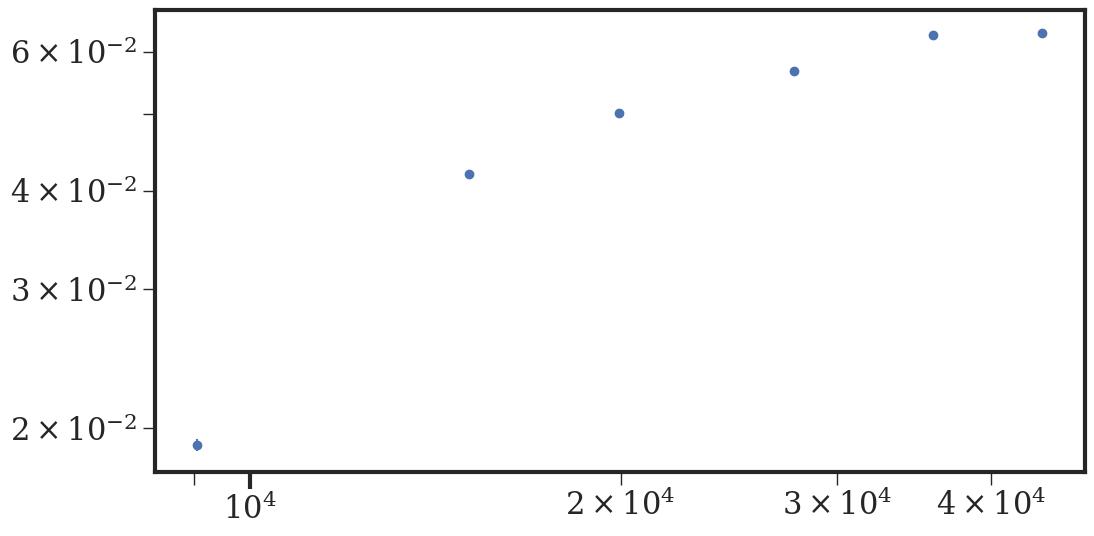

In [16]:
spID = 7  # Select the source to plot (source ID from the catalog)

# Get flux and error in microJanskys for the selected object
sparkle_sed, sparkle_err = get_sed_err(spID)

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Plot observed fluxes with error bars across filter wavelengths
plt.errorbar(
    lam_centers, sparkle_sed, yerr=sparkle_err, marker="o", linestyle=""
)

# Set axes to log scale — important for SEDs covering wide dynamic range
plt.xscale("log")
plt.yscale("log")


plt.show()

### Evaluate Posterior Percentiles
When you fit spectral energy distributions (SEDs) to observed galaxy data, you're not just looking for one best-fit value—you’re interested in the range of possible values for each parameter (like mass, SFR, dust, metallicity, etc.) and how confident you are in them. This is what the posterior distribution from Bayesian inference tells you.
- 50%	The median (best estimate)
- 16%, 84%	The lower and upper bounds of a 68% confidence interval (similar to 1σ if distribution is Gaussian)

In [17]:
get_quants = db.get_quants

def evaluate_posterior_percentiles(
    self, bw_dex=0.001, percentile_values=[50.0, 16.0, 84.0], vb=False
):
    """
    Evaluate summary statistics (percentiles) from the posterior distribution.
    
    Default percentiles:
    - 50%: Median (best estimate)
    - 16%, 84%: Lower and upper 68% confidence bounds
    """

    # Extract percentiles of each parameter from posterior samples
    quants = get_quants(
        self.chi2_array,         # Chi-squared values for all model fits
        self.atlas,              # Atlas: precomputed model grid
        self.norm_fac,           # Normalization factor for model flux
        bw_dex=bw_dex,           # Bandwidth in dex for kernel smoothing
        percentile_values=percentile_values,  # List of percentiles to extract
        vb=vb                    # Verbosity flag
    )

    # Assign extracted percentiles to object's attributes
    self.mstar = quants[0]       # Stellar mass percentiles
    self.sfr = quants[1]         # Star formation rate percentiles
    self.Av = quants[2]          # Dust attenuation percentiles
    self.Z = quants[3]           # Metallicity percentiles
    self.z = quants[4]           # Redshift percentiles
    self.sfh_tuple = quants[5]   # Star formation history percentiles
    self.percentile_values = percentile_values  # Store used percentiles
    return

### Evaluate Posterior Spectra
This function is designed to generate and visualize spectral energy distributions (SEDs) from the posterior probability distribution, summarizing model uncertainties and fitting results.

What it does:

Generate Spectra for Top Models:

- It selects a set of top `ngals` models (with the highest likelihoods).

- It then uses `db.makespec_atlas` to generate model spectra based on those top models.

Organize Results:

 - It collects the wavelengths (`lam_all`), spectra (`spec_all`), and redshifts (`z_all`) for each model.

 - It normalizes each model spectrum by a factor (`self.norm_fac`).

Store Posterior Spectra:

- It assigns `self.spec_post` to hold all posterior spectra.

- The median spectrum (`self.spec_post_med`) is also computed to represent the central tendency of the posterior.

- The observed wavelengths (`self.lam_post`) are calculated by redshifting the model wavelengths.

In [18]:
def evaluate_posterior_spec(
    self,
    filt_centers,
    priors,
    ngals=100,
    alpha=0.1,
    fnu=True,
    yscale="log",
    speccolor="k",
    sedcolor="b",
    titlestr=[],
    figsize=(12, 7),
):

    # Initialize lists to store the generated wavelengths, spectra, and redshifts
    lam_all = []
    spec_all = []
    z_all = []

    # Sort galaxies by likelihood, picking the best models
    bestn_gals = np.argsort(self.likelihood)

    # Loop through the top `ngals` models to generate spectra
    for i in range(ngals):

        # Generate model spectrum for each top galaxy
        lam_gen, spec_gen = db.makespec_atlas(
            self.atlas,               # The model atlas/grid of galaxy properties
            bestn_gals[-(i + 1)],     # Select the best-fit model from the sorted list
            priors,                   # Priors for the model parameters
            db.mocksp,                # Mock spectrum function
            db.cosmo,                 # Cosmological parameters
            filter_list=[],           # No filters applied here
            filt_dir=[],              # No filter directory specified
            return_spec=True,         # Return the generated spectrum
        )

        # Append the generated wavelengths, spectrum (normalized), and redshift to the lists
        lam_all.append(lam_gen)
        spec_all.append(spec_gen * self.norm_fac)  # Apply normalization factor
        z_all.append(self.atlas["zval"][bestn_gals[-(i + 1)]])  # Redshift of the model

    # Convert lists to numpy arrays for easy handling and processing
    self.spec_post = np.array(spec_all)               # Store all posterior spectra
    self.spec_post_med = np.nanmedian(self.spec_post, 0)  # Median spectrum across all models
    self.lam_post = lam_all[0] * (1 + z_all[0])       # Wavelengths redshifted by the median redshift

    return


### Run DB fit

Eazy z_50:  1.35 Eazy z_width:  0.1
15.738364369035766
couldnt set axis limits


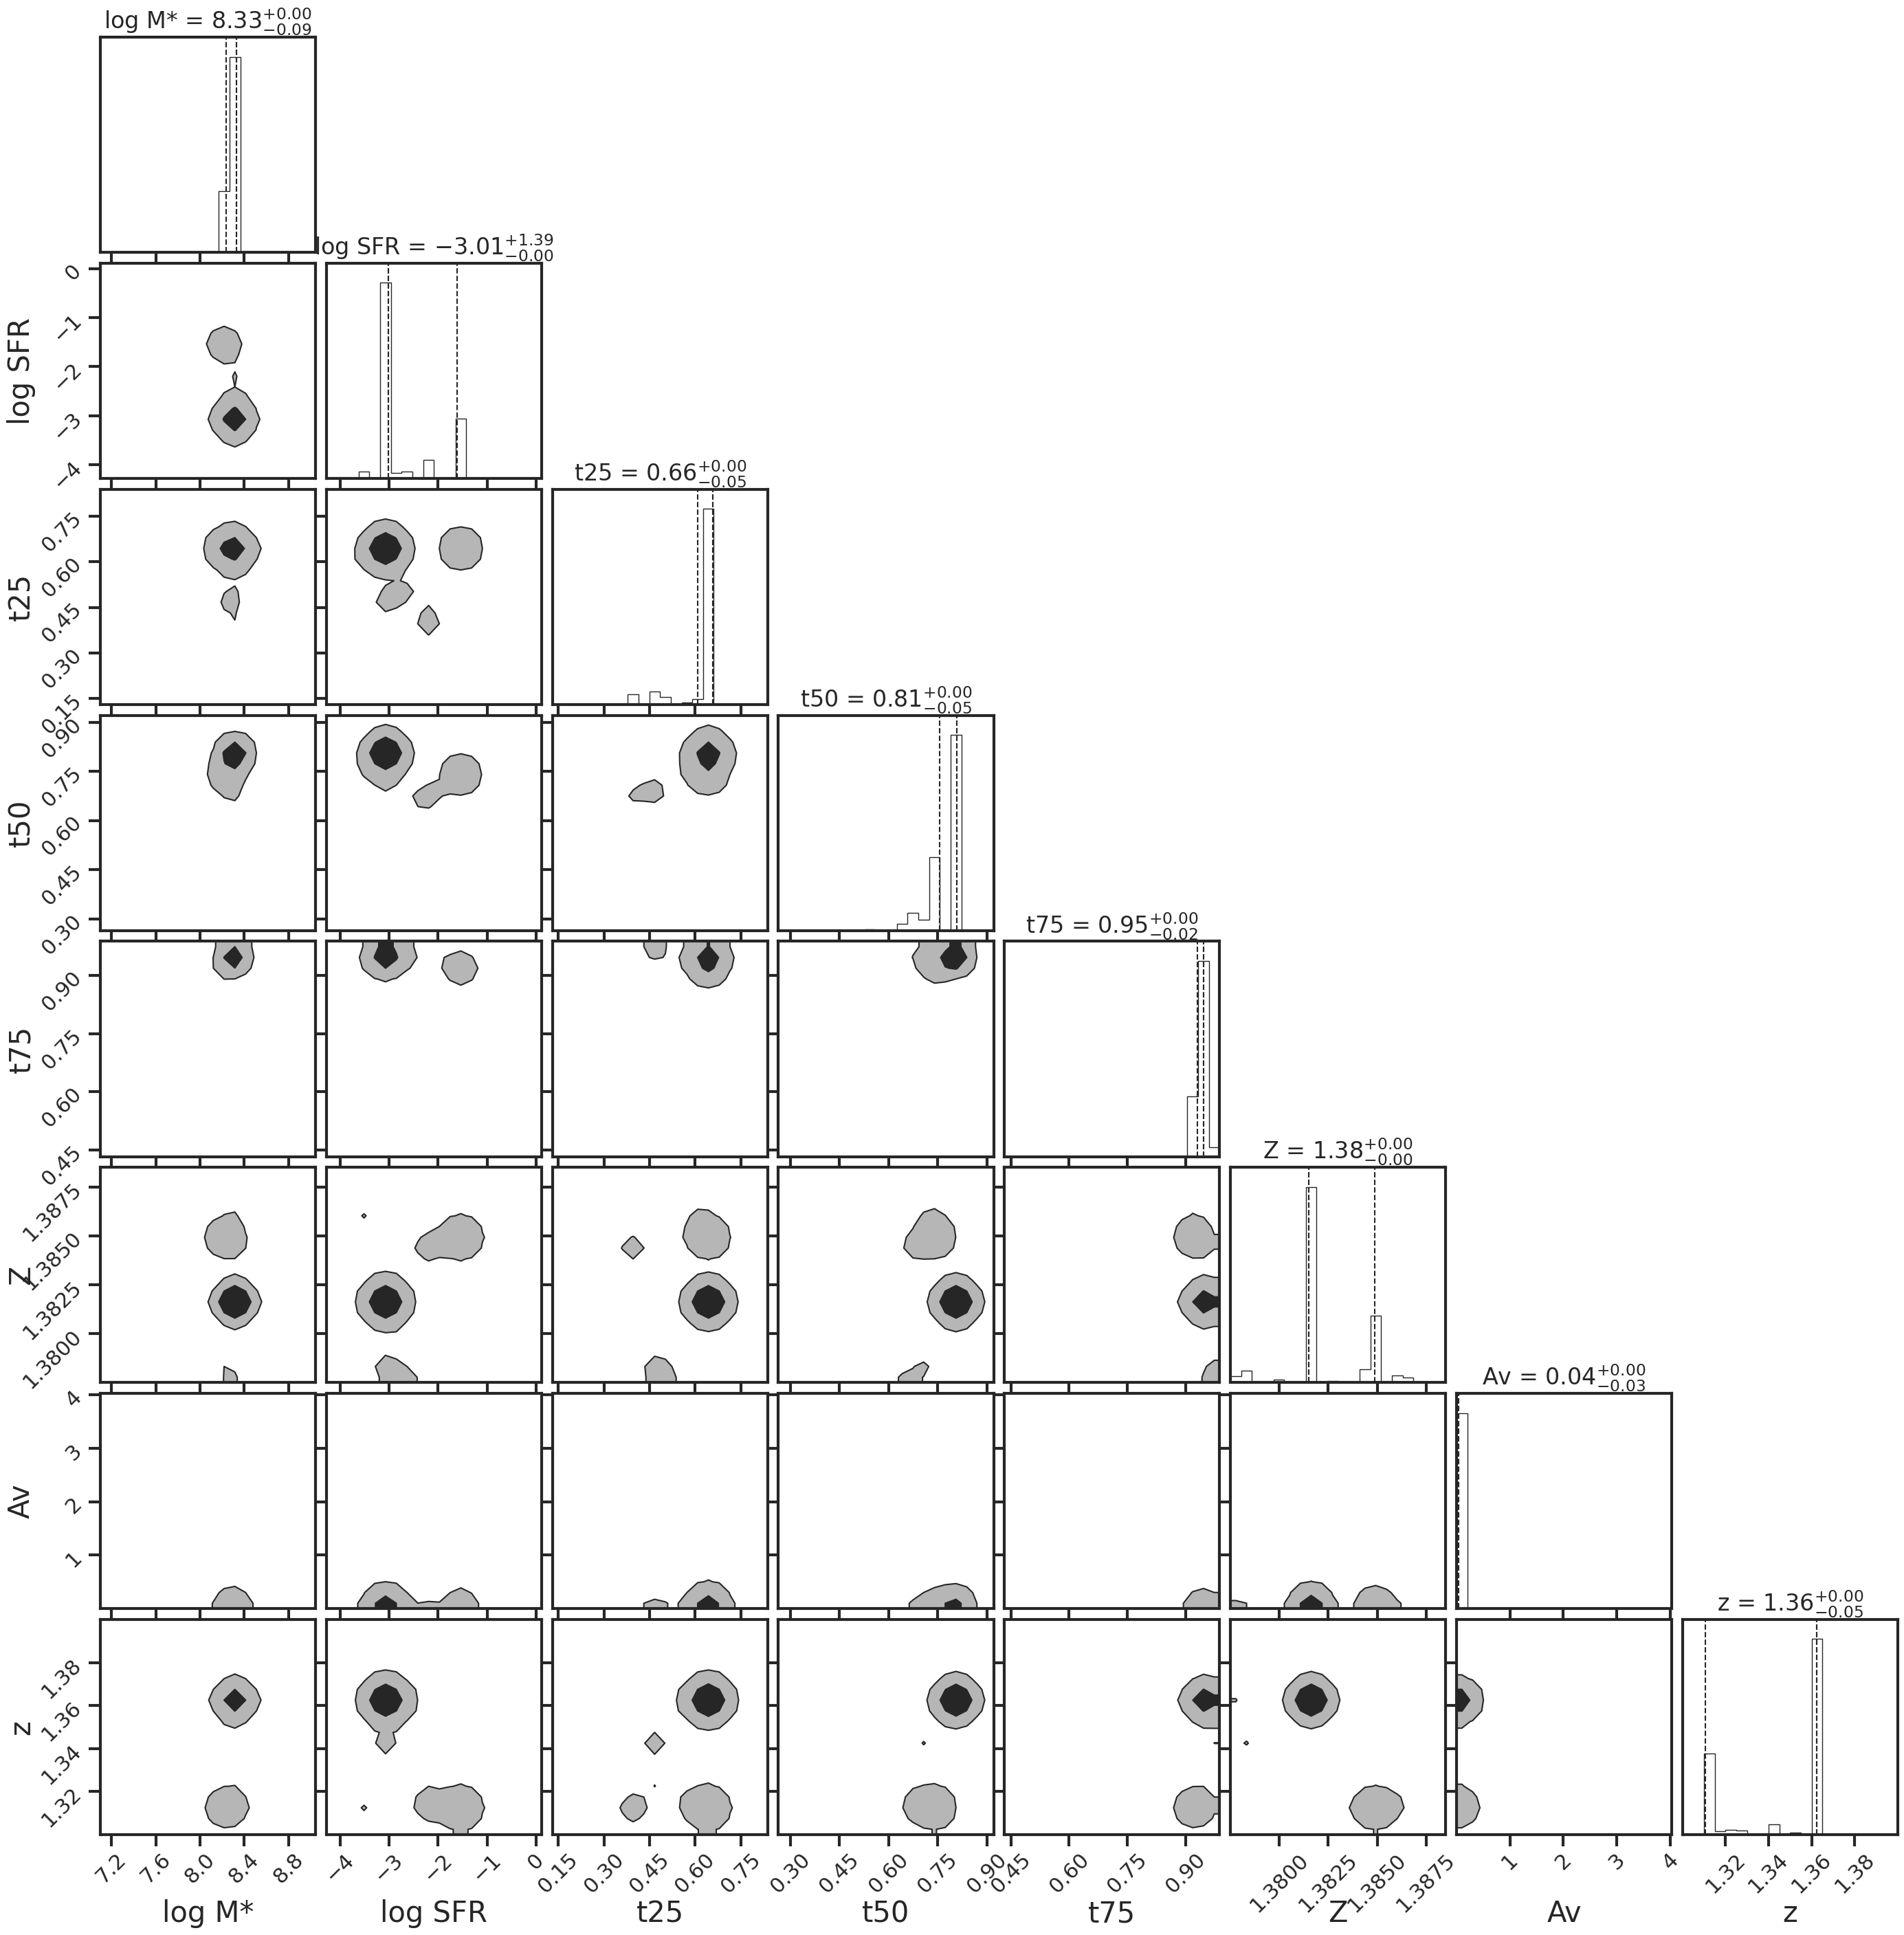

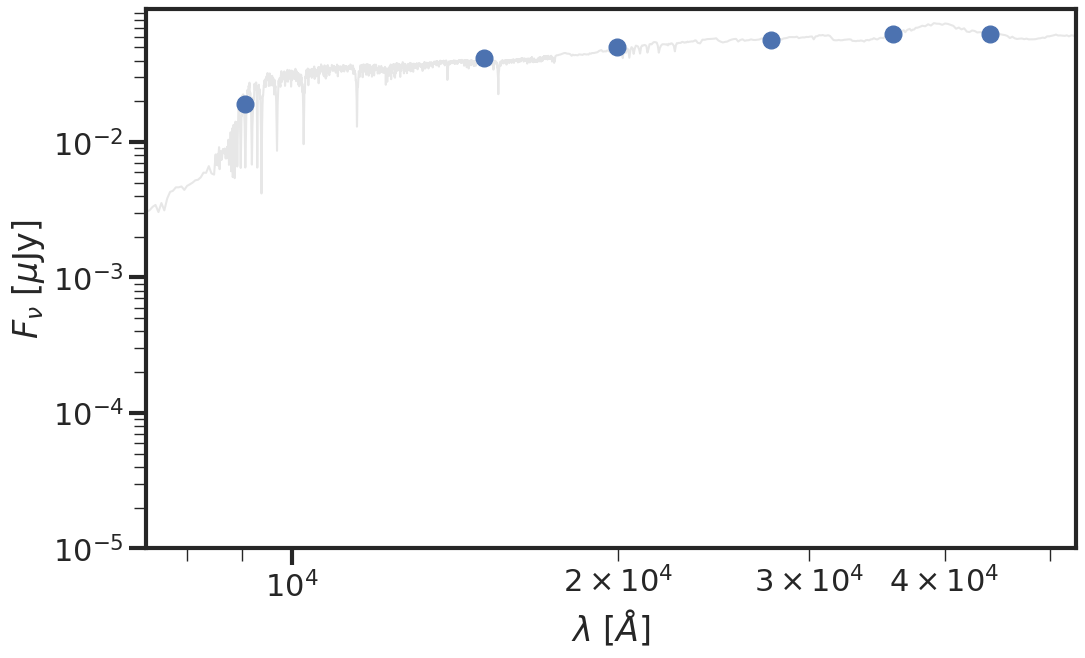

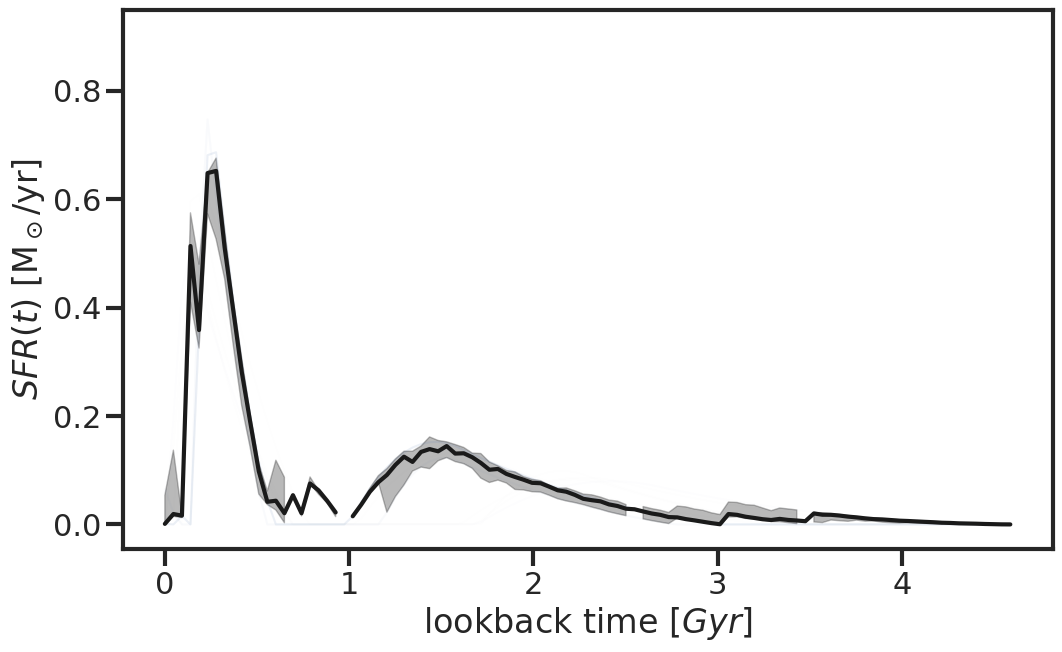

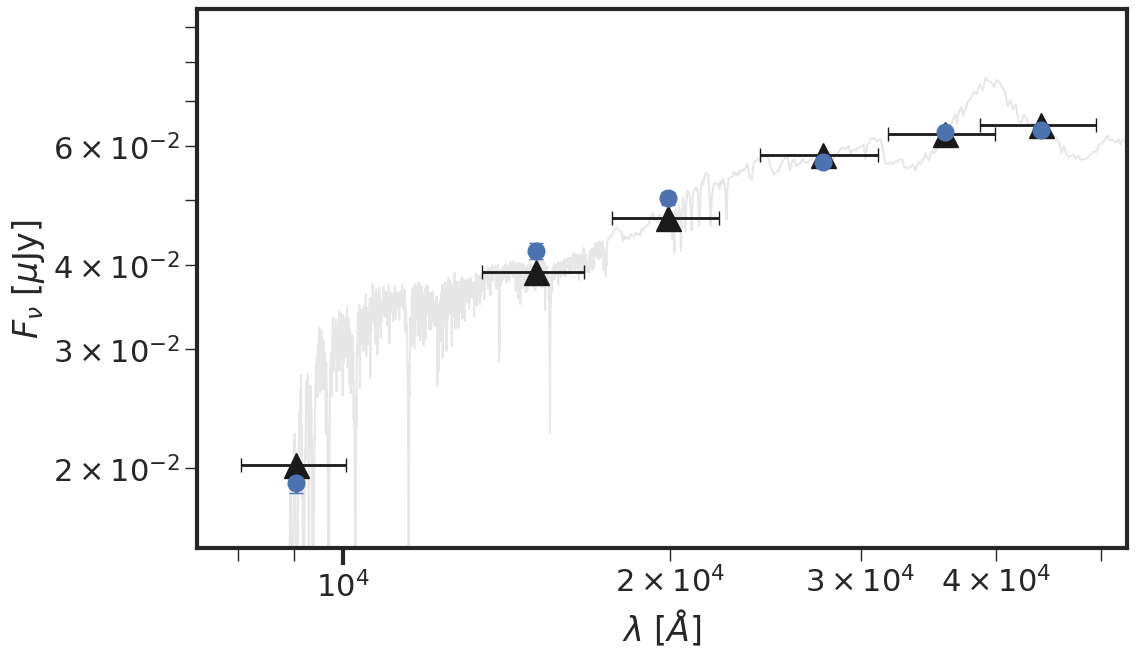

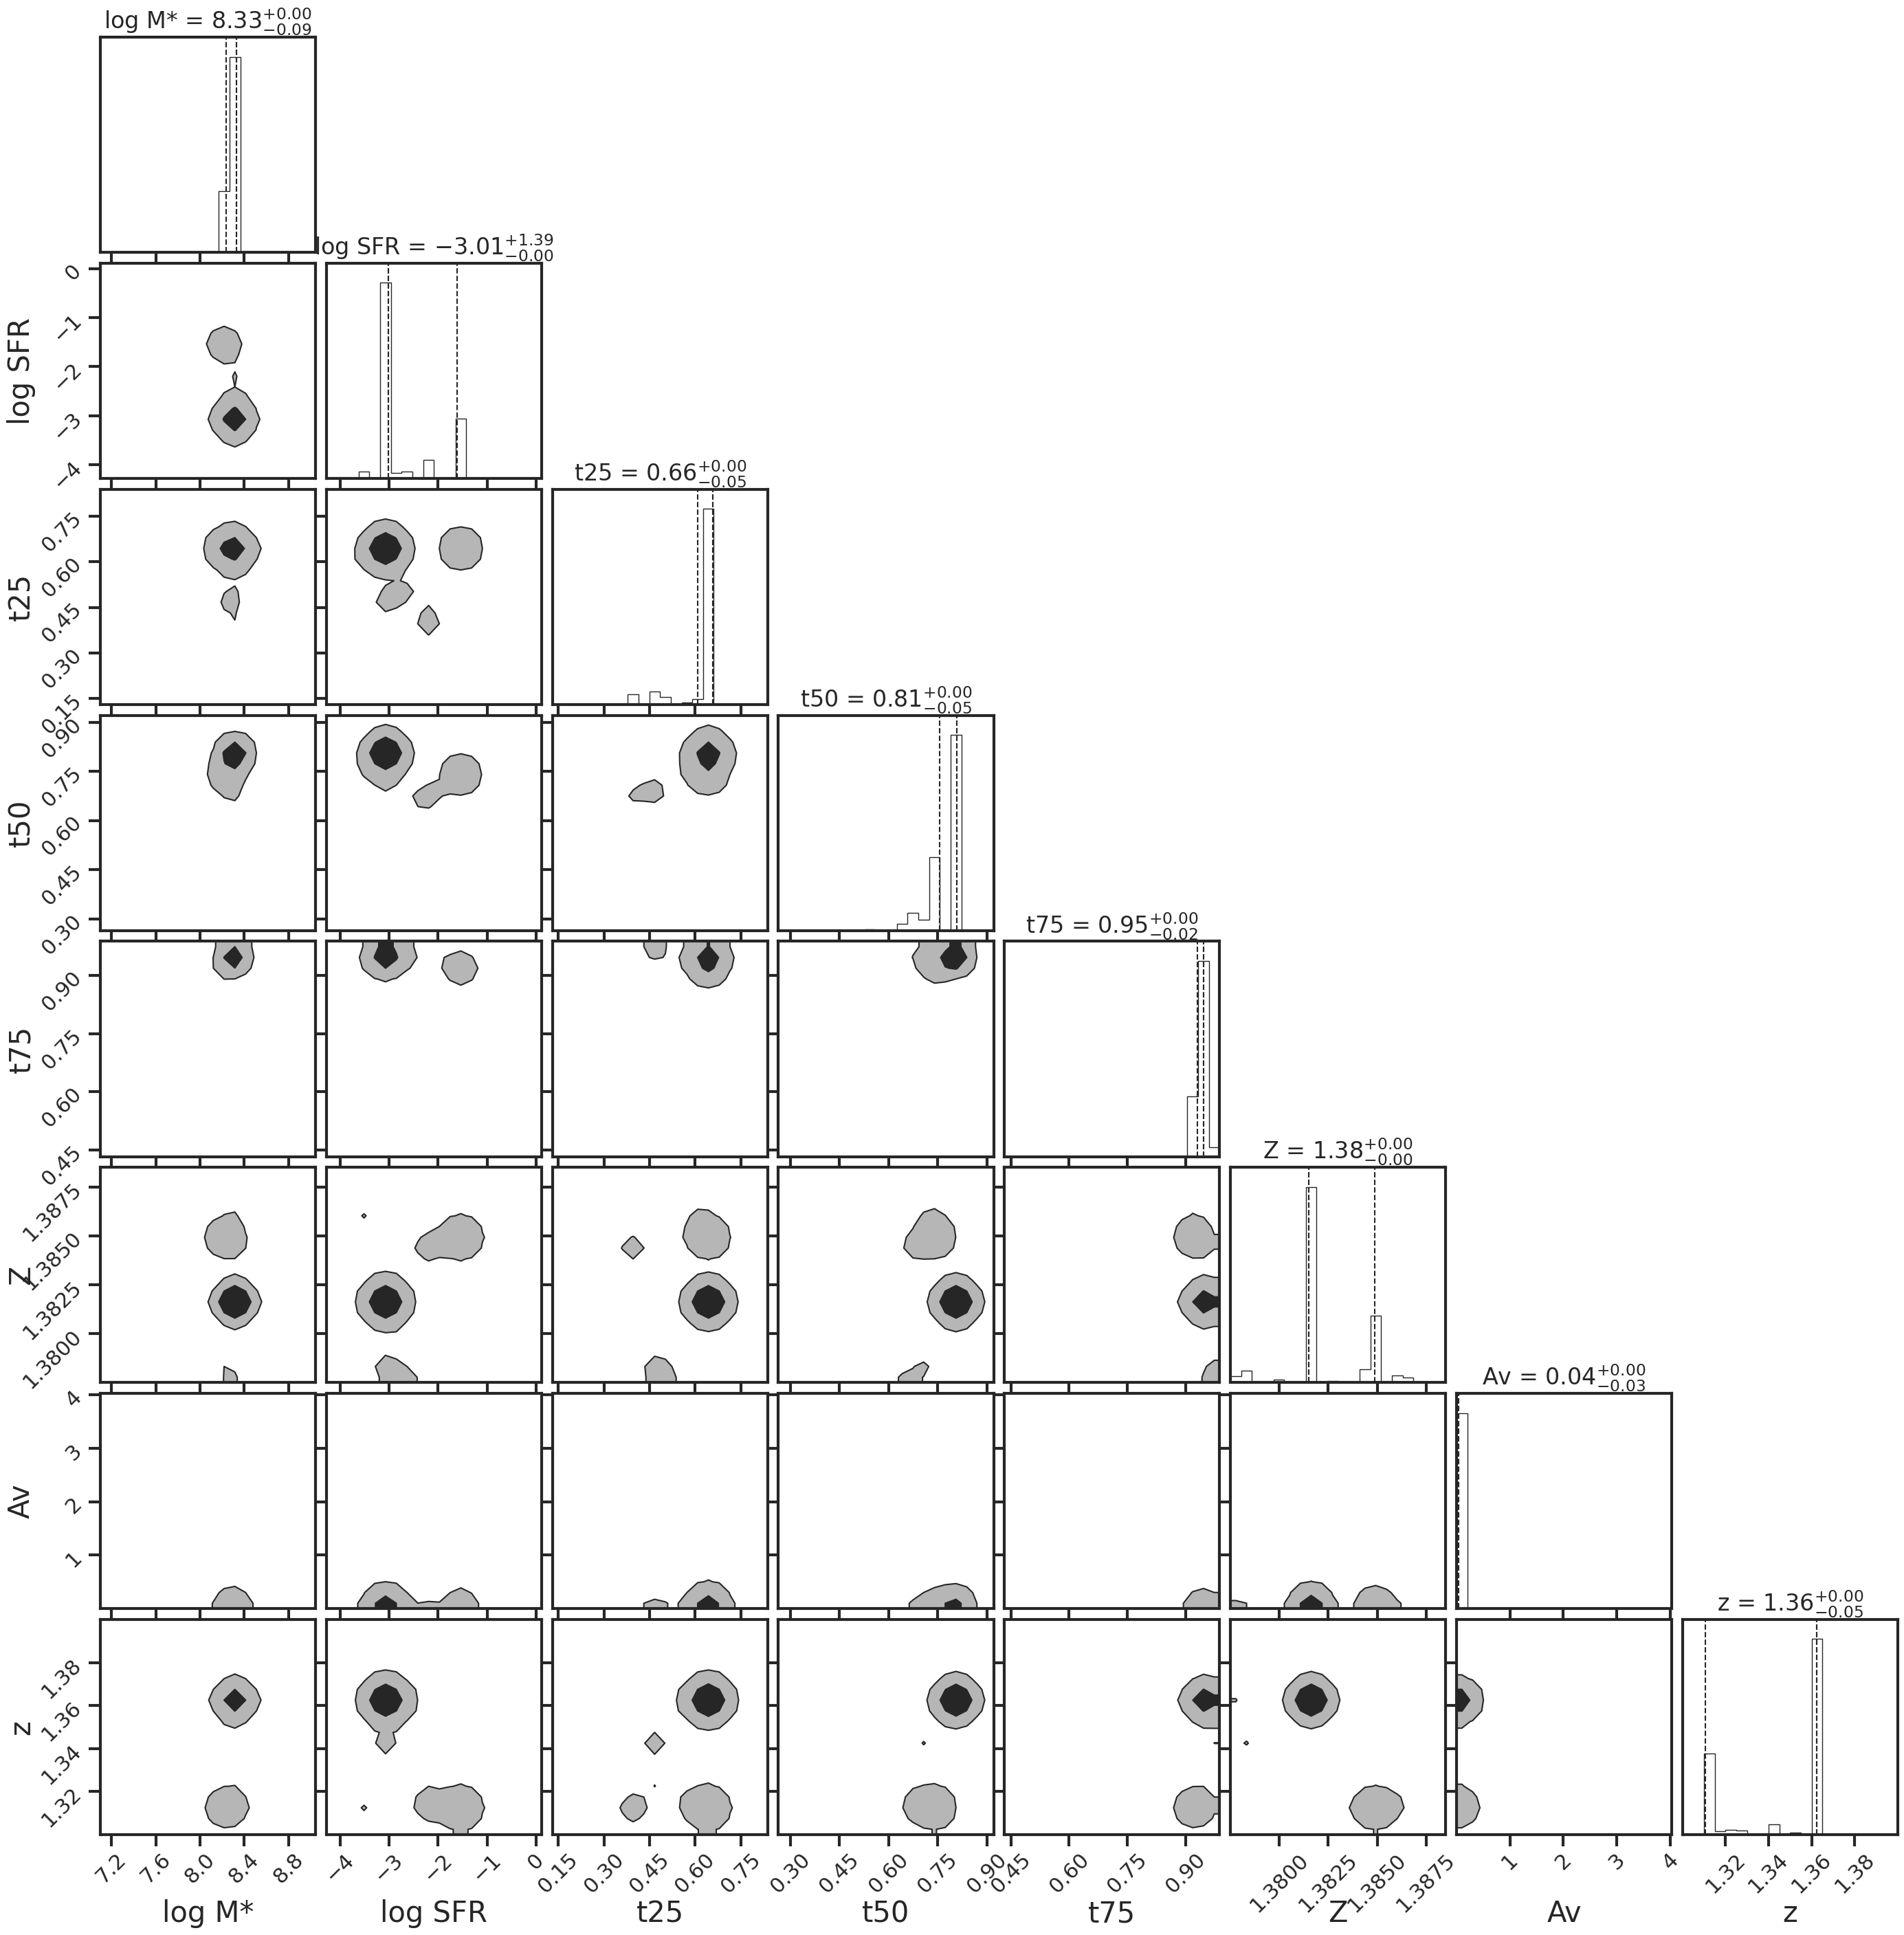

In [19]:
spID = 7

# Retrieve the SED (Spectral Energy Distribution) and its associated error for the selected galaxy
sparkle_sed, sparkle_err = get_sed_err(spID)

# Store for fitting
sed = sparkle_sed
err = sparkle_err

# Create a mask to ignore fluxes that are zero or negative
fit_mask = sed > 0

# Redshift setup: use redshift from an external photo-z code (e.g., EAZY), or choose to fit it
fit_z = False

# If redshift is negative or fitting is requested, use broad redshift prior
if (eazy_z < 0) or (fit_z == True):
    eazy_z = 1.3775
    eazy_zw = 4

print("Eazy z_50: ", eazy_z, "Eazy z_width: ", eazy_zw)

# Instantiate a SedFit object, which holds all the fitting machinery for a single galaxy
# Inputs: observed SED, error, model atlas, fit mask, and redshift prior
sedfit = db.SedFit(sed, err, atlas, fit_mask=fit_mask, zbest=eazy_z, deltaz=eazy_zw)

# Evaluate likelihood over the model atlas using the observed data
sedfit.evaluate_likelihood()

# Get the posterior parameter percentiles (e.g., median, 68% confidence intervals)
evaluate_posterior_percentiles(sedfit)

# Compute the posterior spectral distributions by sampling from best-fit models
evaluate_posterior_spec(sedfit, lam_centers, priors)

# Output the minimum chi-squared (fit quality metric)
print(np.amin(sedfit.chi2_array))

# Plot the posterior spectrum with error bars showing photometry
# This includes multiple realizations from the posterior
sedfit.plot_posterior_spec(filt_centers=lam_centers, priors=priors, fnu=True, ngals=1)
tempy = plt.ylim()
plt.ylim(1e-5, tempy[1])  # Optional: constrain y-axis if needed
# plt.show()

# Plot the posterior Star Formation History (SFH), showing how star formation evolved over time
sedfit.plot_posterior_SFH(zval=eazy_z)
#plt.ylim(0, 25)  # Optional: y-axis limit

# Plot another realization of the posterior spectrum for visual clarity
sedfit.plot_posterior_spec(filt_centers=lam_centers, priors=priors, fnu=True, ngals=1)

# Plot best-fit photometry points on top of the posterior spectrum
bfsed = atlas["sed"][np.argmin(sedfit.chi2_array), 0:] * sedfit.norm_fac
plt.plot(lam_centers, bfsed, "k^", markersize=18)
plt.errorbar(
    lam_centers,
    bfsed,
    xerr=(lam_widths / 2, lam_widths / 2),  # Symmetric x-errors showing filter widths
    lw=0,
    elinewidth=2,
    color="k",
    capsize=5,
)

# Plot posterior distributions for derived physical parameters (mass, SFR, dust, metallicity, etc.)
sedfit.plot_posteriors()

In [20]:
# stellar mass, SFR, dust, metallicity, redshift
sedfit.mstar, sedfit.sfr, sedfit.Av, sedfit.Z, sedfit.z

(array([8.3285, 8.2385, 8.3315]),
 array([-3.0145, -3.0805, -1.6245]),
 array([0.0365, 0.0065, 0.0375]),
 array([nan, nan, nan]),
 array([1.3605007, 1.3105007, 1.3625007]))

In [21]:
evaluate_posterior_spec(sedfit, lam_centers, priors)

Text(0, 0.5, 'F$_\\nu$ [$\\mu$Jy]')

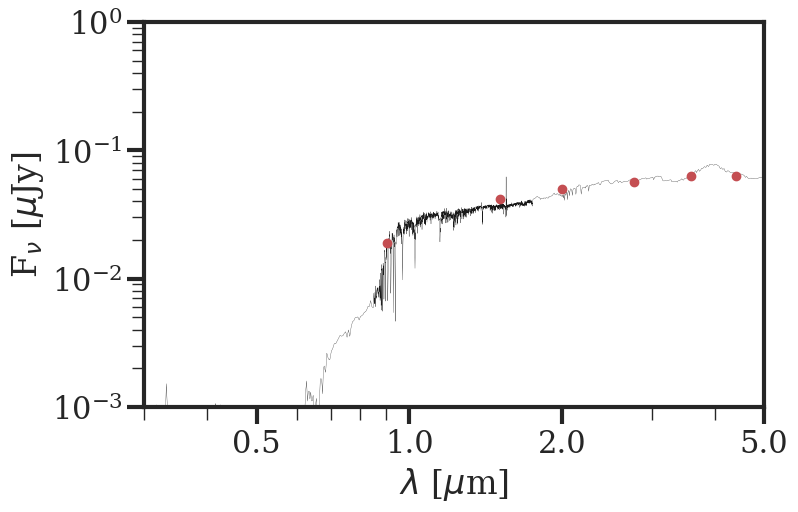

In [22]:
font = {"family": "serif", "size": 8}
rc("font", **font)

f, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.loglog(sedfit.lam_post / 1e4, sedfit.spec_post_med, c="k", lw=0.2)
ax.errorbar(
    lam_centers / 1e4, sparkle_sed, yerr=sparkle_err, c="r", marker="o", linestyle=""
)

ax.set_ylim(1e-3, 1)
ax.set_xlim(0.3, 5)
xticks = np.asarray((0.5, 1, 2, 5))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set_xlabel(r"$\lambda$ [$\mu$m]")
ax.set_ylabel(r"F$_\nu$ [$\mu$Jy]")

### Posterior SFH Estimation and SED Likelihood Evaluation Functions

In [23]:
set_plot_style = db.set_plot_style
cosmo = db.cosmo
tuple_to_sfh = db.tuple_to_sfh
calc_percentiles = db.calc_percentiles
minimize = db.minimize
normerr = db.normerr
Table = db.Table

def get_posterior_SFH(
    self, zval, ngals=100, alpha=0.1, speccolor="k", sedcolor="b", figsize=(12, 7)
):
    """
    Compute the posterior star formation history (SFH) from the best-fit SED models.

    Parameters
    ----------
    self : object
        Object containing SED fit results and model atlas.
    zval : float
        Redshift of the observed galaxy.
    ngals : int, optional
        Number of best models to include in posterior SFH (default is 100).
    speccolor : str, optional
        Color for spectral plots (default is 'k').
    sedcolor : str, optional
        Color for SED plots (default is 'b').
    figsize : tuple, optional
        Size of figure if plotting (default is (12, 7)).

    Returns
    -------
    sfh_50 : ndarray
        Median SFH values.
    sfh_16 : ndarray
        16th percentile SFH values.
    sfh_84 : ndarray
        84th percentile SFH values.
    common_time : ndarray
        Common time axis in Gyr.
    """
    set_plot_style()
    bestn_gals = np.argsort(self.likelihood)

    common_time = np.linspace(0, cosmo.age(zval).value, 100)
    if priors.dynamic_decouple == True:
        priors.decouple_sfr_time = 100 * cosmo.age(zval).value / cosmo.age(0.1).value

    all_sfhs = []
    all_weights = []
    for i in range(ngals):
        sfh, timeax = tuple_to_sfh(
            self.atlas["sfh_tuple"][bestn_gals[-(i + 1)], 0:],
            self.atlas["zval"][bestn_gals[-(i + 1)]],
        )
        sfh = sfh * self.norm_fac
        sfh_interp = np.flip(np.interp(common_time, timeax, np.flip(sfh, 0)), 0)
        all_sfhs.append(sfh_interp)
        all_weights.append(self.likelihood[bestn_gals[-(i + 1)]])

    all_sfhs = np.array(all_sfhs)
    all_weights = np.array(all_weights)

    sfh_50 = np.zeros_like(common_time)
    sfh_16 = np.zeros_like(common_time)
    sfh_84 = np.zeros_like(common_time)
    for ti in range(len(common_time)):
        qty = np.log10(all_sfhs[0:, ti])
        qtymask = (qty > -np.inf) & (~np.isnan(qty))
        if np.sum(qtymask) > 0:
            smallwts = all_weights.copy()[qtymask.ravel()]
            qty = qty[qtymask]
            if len(qty > 0):
                sfh_50[ti], sfh_16[ti], sfh_84[ti] = 10 ** calc_percentiles(
                    qty, smallwts, bins=50, percentile_values=[50.0, 16.0, 84.0]
                )

    return sfh_50, sfh_16, sfh_84, common_time


def evaluate_likelihood(self):
    
    """
    Evaluate and store likelihood values and normalization factor for the SED fit.

    Parameters
    ----------
    self : object
        Object containing observed SED and model atlas.
        
    """
    chi2_array, norm_fac = evaluate_sed_likelihood(
        self.sed,
        self.sed_err,
        self.atlas,
        self.fit_mask,
        self.zbest,
        self.deltaz,
        self.dynamic_norm,
    )
    self.chi2_array = chi2_array
    self.norm_fac = norm_fac
    self.likelihood = np.exp(-(chi2_array) / 2)

    return


def evaluate_sed_likelihood(
    sed, sed_err, atlas, fit_mask=[], zbest=None, deltaz=None, dynamic_norm=True
):
    """
    Evaluate chi² likelihoods for matching model SEDs to an observed SED.

    Parameters
    ----------
    sed : ndarray
        Observed spectral energy distribution.
    sed_err : ndarray
        Observational uncertainties in the SED.
    atlas : dict
        Dictionary of model SEDs and redshifts.
    fit_mask : list of bool, optional
        Boolean mask to include valid SED entries (default uses sed > 0).
    zbest : float, optional
        Best-estimate redshift to limit redshift range.
    deltaz : float, optional
        Redshift tolerance for model matching.
    dynamic_norm : bool, optional
        Whether to optimize normalization dynamically.

    Returns
    -------
    chi2 : ndarray
        Chi² values for each model.
    norm_fac : float
        Best-fit normalization factor.
    """
    if len(fit_mask) == len(sed):
        fit_mask = fit_mask & (sed > 0)
    else:
        fit_mask = sed > 0

    if len(sed) != len(sed_err):
        raise ValueError("SED uncertainty array does not match SED")

    sed = sed[fit_mask]
    sed_err = sed_err[fit_mask]
    pg_seds = atlas["sed"].copy().T

    if zbest is not None:
        pg_z = atlas["zval"].ravel()
        redshift_mask = np.abs(pg_z - zbest) < deltaz
        chi2 = np.zeros((len(pg_z),))
        chi2[~redshift_mask] = 1e10
        if np.sum(redshift_mask) == 0:
            print("atlas does not contain any models in redshift range")

    norm_fac = np.nanmedian(sed)
    temp_sed_normed = sed.reshape(-1, 1) / norm_fac
    temp_sed_err_normed = sed_err.reshape(-1, 1) / norm_fac

    if zbest is not None:
        chi2[redshift_mask] = np.mean(
            (pg_seds[fit_mask, 0:][0:, redshift_mask] - temp_sed_normed) ** 2
            / (temp_sed_err_normed) ** 2,
            0,
        )
    else:
        chi2 = np.mean(
            (pg_seds[fit_mask, 0:] - temp_sed_normed) ** 2 / (temp_sed_err_normed) ** 2,
            0,
        )

    norm_mask = np.argsort(chi2)[0:10]
    if dynamic_norm == True:
        nfmin = minimize(
            normerr,
            np.nanmedian(sed),
            args=(pg_seds[0:, norm_mask], sed, sed_err, fit_mask),
        )
        norm_fac = nfmin["x"][0]
    elif dynamic_norm == False:
        norm_fac = np.nanmedian(sed)
    else:
        norm_fac = 1.0
        print("undefined norm method. using norm_fac = 1")

    sed_normed = sed.reshape(-1, 1) / norm_fac
    sed_err_normed = sed_err.reshape(-1, 1) / norm_fac

    if zbest is not None:
        chi2[redshift_mask] = np.mean(
            (pg_seds[fit_mask, 0:][0:, redshift_mask] - sed_normed) ** 2
            / (sed_err_normed) ** 2,
            0,
        )
    else:
        chi2 = np.mean(
            (pg_seds[fit_mask, 0:] - sed_normed) ** 2 / (sed_err_normed) ** 2, 0
        )

    return chi2, norm_fac

### SED Fitting and SFH Posterior Extraction

In [24]:
# IDs / cluster name for this run
idno = 1
cluster_name = "Sparkler_BCGs"

# Base directory for saving Dense Basis outputs
base_dir = os.path.join(os.getcwd(), "dense_basis_plot", f"posteriors-{idno}_{cluster_name}")

# Create folders if they don't exist
plots_dir = os.path.join(base_dir, "plots")
fits_dir = os.path.join(base_dir, "fits")
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(fits_dir, exist_ok=True)

# Initialize storage lists
all_sedfits, all_masses, all_sfrs, all_t50s = [], [], [], []
all_db_chi2, all_sed, all_sederr, all_Zs, all_bfsed = [], [], [], [], []
all_sfh_50, all_sfh_16, all_sfh_84, all_timeax = [], [], [], []

# Loop over each galaxy
for spID in spIDs:
    sparkle_sed, sparkle_err = get_sed_err(spID)
    sed = sparkle_sed
    err = sparkle_err + 1e-4  # small error for stability
    fit_mask = sed > 0

    zval = eazy_z
    fit_z = False
    if (eazy_z < 0) or fit_z:
        eazy_z = 5.0
        eazy_zw = 10.0
    print(f"Eazy z_50: {eazy_z}, Eazy z_width: {eazy_zw}")

    # Perform SED fitting
    sedfit = db.SedFit(sed, err, atlas, fit_mask=fit_mask, zbest=eazy_z, deltaz=eazy_zw)
    sedfit.evaluate_likelihood()
    evaluate_posterior_percentiles(sedfit)
    evaluate_posterior_spec(sedfit, lam_centers, priors)
    print(f"Min chi2: {np.amin(sedfit.chi2_array)}")

    # Posterior SFH
    sfh_50, sfh_16, sfh_84, common_time = get_posterior_SFH(sedfit, zval=sedfit.z[0])
    all_sfh_50.append(sfh_50)
    all_sfh_16.append(sfh_16)
    all_sfh_84.append(sfh_84)
    all_timeax.append(common_time)

    # === Plot posterior spectrum ===
    sedfit.plot_posterior_spec(filt_centers=lam_centers, priors=priors, fnu=True, ngals=1)
    tempy = plt.ylim()
    plt.ylim(1e-5, tempy[1])
    bfsed = atlas["sed"][np.argmin(sedfit.chi2_array), :] * sedfit.norm_fac
    plt.plot(lam_centers, bfsed, "k^", markersize=18)
    plt.errorbar(lam_centers, bfsed, xerr=(lam_widths / 2,), lw=0, elinewidth=2, color="k", capsize=5)
    plt.savefig(os.path.join(plots_dir, f"{spID}_spec.png"), bbox_inches="tight")
    plt.close()

    # === Posterior SFH plot ===
    sedfit.plot_posterior_SFH(zval=eazy_z)
    plt.savefig(os.path.join(plots_dir, f"{spID}_SFH.png"), bbox_inches="tight")
    plt.close()

    # === Posterior parameters ===
    sedfit.plot_posteriors()
    plt.savefig(os.path.join(plots_dir, f"{spID}_posteriors.png"), bbox_inches="tight")
    plt.close()

    # Store results
    all_sedfits.append(sedfit)
    all_masses.append(sedfit.mstar)
    all_sfrs.append(sedfit.sfr)
    all_Zs.append(sedfit.Z)
    all_t50s.append((1 - sedfit.sfh_tuple[:, 3]) * db.cosmo.age(zval).value)
    all_db_chi2.append(np.amin(sedfit.chi2_array))
    all_sed.append(sed)
    all_sederr.append(err)
    all_bfsed.append(bfsed)

# === Save all results to HDF5 ===
fit_data = [
    all_sedfits,
    all_masses,
    all_sfrs,
    all_t50s,
    all_sed,
    all_sederr,
    all_db_chi2,
    lam_centers,
]

output_file = os.path.join(fits_dir, f"test_{idno}_fits.h5")
hickle.dump(fit_data, output_file)
print(f"✅ Saved all results to: {output_file}")

Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 10.74690707651063
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 56.87359542586163
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 68.33008244059818
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 46.57865691002778
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 92.76978072989625
couldnt set axis limits
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 49.66985607274416
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 38.38988941064801
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 42.010395876850374
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 46.337780928899946
Eazy z_50: 1.35, Eazy z_width: 0.1
Min chi2: 69.5470420174313
couldnt set axis limits
✅ Saved all results to: /home/tanmoy/Sparkler_BCGs_OUT_BEE/Dense basis SOl/dense_basis_plot/posteriors-1_Sparkler_BCGs/fits/test_1_fits.h5


In [25]:
sedfit.Z

array([nan, nan, nan])

### Plot SED Fits for All Sources

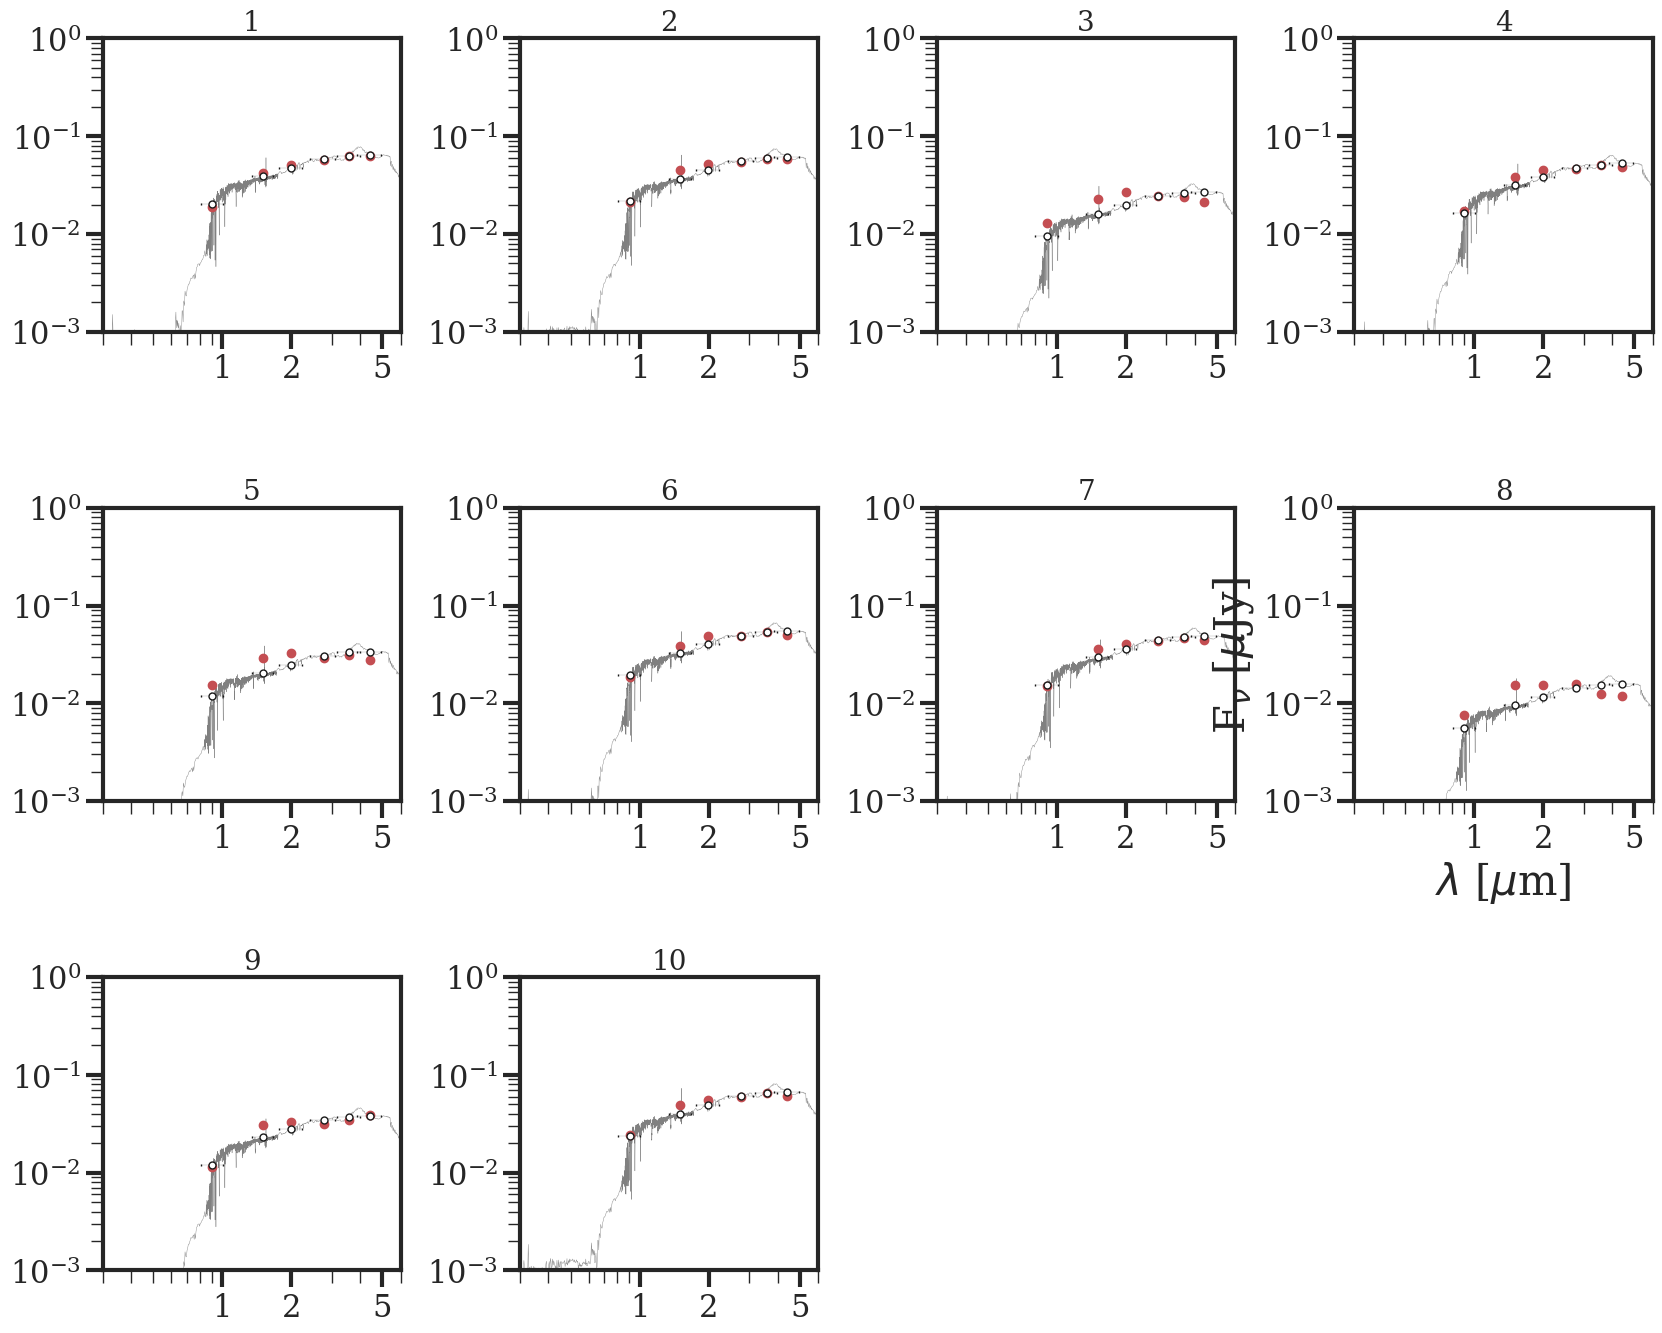

In [26]:
# Set font properties for all plots
font = {"family": "serif", "size": 8}
rc("font", **font)

# Create a 3x3 grid of subplots with specified figure size
f, axes = plt.subplots(3, 4, figsize=(20, 16))
axs = axes.ravel()  # Flatten the 2D axes array into a 1D array for easy indexing

# Loop over all sources and plot their SEDs
for i in range(len(tphot)):
    ax = axs[i]

    # Plot the model posterior spectrum (median) in grey
    ax.loglog(
        all_sedfits[i].lam_post / 1e4,  # Convert from Angstroms to microns
        all_sedfits[i].spec_post_med,
        c="grey", lw=0.3
    )

    # Plot observed photometry with red error bars
    ax.errorbar(
        lam_centers / 1e4,
        all_sed[i],
        yerr=all_sederr[i],
        c="r",
        marker="o",
        linestyle="",
        ms=6,
    )

    # Plot best-fit photometric model values as open circles
    ax.plot(
        lam_centers / 1e4,
        all_bfsed[i],
        "o",
        markersize=5,
        mec="k",  # black edge
        zorder=10,
        mfc="w"   # white face
    )

    # Add horizontal error bars for filter width
    ax.errorbar(
        lam_centers / 1e4,
        all_bfsed[i],
        xerr=(lam_widths / 2 / 1e4, lam_widths / 2 / 1e4),
        lw=0,
        elinewidth=0.1,
        color="k",
        capsize=1,
    )

    # Set y-axis and x-axis limits
    ax.set_ylim(1e-3, 1)
    ax.set_xlim(0.3, 6)

    # Set consistent x-ticks across all plots
    xticks = np.asarray((1, 2, 5))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)

    # Set title as the source index
    ax.set_title(i + 1, fontsize=20)

# Add shared axis labels to a middle plot
axs[-5].set_xlabel(r"$\lambda$ [$\mu$m]", fontsize=30)
axs[-5].set_ylabel(r"F$_\nu$ [$\mu$Jy]", fontsize=30)

# Hide the two extra subplot panels (in case len(tphot) < 9)
axs[-1].axis("off")
axs[-2].axis("off")

# Adjust spacing between subplots
f.subplots_adjust(wspace=0.4, hspace=0.6)

# Uncomment to save the figure
# plt.savefig('allsparkles_testdbfit.png', dpi=300, bbox_inches='tight')

In [28]:
# deriving the t50s from the SFHs directly
from IPython.display import display, Math, Latex

all_t50s_sfh = []
all_mass_sfh = []
all_sfr_sfh = []
all_ssfr_sfh = []
for i in range(len(all_t50s)):
    tempsfh = all_sfh_50[i]
    tempsfh[np.isnan(tempsfh)] = 0.0
    all_t50s_sfh.append((1-db.calctimes(all_timeax[i], tempsfh,1)[2][0]) * db.cosmo.age(zval).value)
    temp1 = db.calctimes(all_timeax[i], all_sfh_50[i],1)[1] - db.calctimes(all_timeax[i], all_sfh_50[i],1)[0]
    all_ssfr_sfh.append(temp1)
    all_mass_sfh.append(db.calctimes(all_timeax[i], all_sfh_50[i],1)[0])
    all_sfr_sfh.append(db.calctimes(all_timeax[i], all_sfh_50[i],1)[1])
    
for i in range(len(all_t50s)):
    display(Math('\mathrm{Clump~ %.0f ~|~} t_{50}: %.1f^{+ %.1f}_{- %.1f} \mathrm{~Myr}' %(i+1, all_t50s_sfh[i]*1e3, all_t50s[i][1]*1e3-all_t50s_sfh[i]*1e3, all_t50s_sfh[i]*1e3-all_t50s[i][2]*1e3)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Derive physical properties from posterior SFHs and display them


In [29]:

from IPython.display import display, Math

all_t50s_sfh = []
all_mass_sfh = []
all_sfr_sfh = []
all_ssfr_sfh = []

for i in range(len(all_t50s)):
    tempsfh = all_sfh_50[i]
    tempsfh[np.isnan(tempsfh)] = 0.0

    # Calculate t50
    t50_sfh = (1 - db.calctimes(all_timeax[i], tempsfh, 1)[2][0]) * db.cosmo.age(zval).value
    all_t50s_sfh.append(t50_sfh)

    # Calculate stellar mass, SFR, and sSFR
    mass = db.calctimes(all_timeax[i], tempsfh, 1)[0]
    sfr = db.calctimes(all_timeax[i], tempsfh, 1)[1]
    ssfr = sfr - mass if mass > 0 else 0.0

    all_mass_sfh.append(mass)
    all_sfr_sfh.append(sfr)
    all_ssfr_sfh.append(ssfr)

    # Display all properties with LaTeX
    display(Math(
        r'\mathrm{Clump~%d~|~} t_{{50}}: %.1f^{{+%.1f}}_{{-%.1f}}~\mathrm{Myr},~ '
        r'M_*: %.2e~M_\odot,~ \mathrm{SFR}: %.2f~M_\odot/\mathrm{yr},~ '
        r'\mathrm{sSFR}: %.2e~\mathrm{yr}^{{-1}}' % (
            i + 1,
            t50_sfh * 1e3,
            all_t50s[i][1] * 1e3 - t50_sfh * 1e3,
            t50_sfh * 1e3 - all_t50s[i][2] * 1e3,
            mass,
            sfr,
            ssfr
        )
    ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
import pandas as pd
import numpy as np
from IPython.display import display, Math

# Lists to store SFH-derived properties
all_t50s_sfh = []
all_mass_sfh = []
all_sfr_sfh = []
all_ssfr_sfh = []

# Table data for CSV
all_table_data = []

for i in range(len(all_t50s)):
    tempsfh = all_sfh_50[i]
    tempsfh[np.isnan(tempsfh)] = 0.0

    # Calculate t50
    t50_sfh = (1 - db.calctimes(all_timeax[i], tempsfh, 1)[2][0]) * db.cosmo.age(zval).value
    all_t50s_sfh.append(t50_sfh)

    # Stellar mass, SFR, sSFR
    mass = db.calctimes(all_timeax[i], tempsfh, 1)[0]
    sfr = db.calctimes(all_timeax[i], tempsfh, 1)[1]
    ssfr = sfr / mass if mass > 0 else 0.0  # sSFR = SFR / M_star

    all_mass_sfh.append(mass)
    all_sfr_sfh.append(sfr)
    all_ssfr_sfh.append(ssfr)

    # Display in LaTeX
    display(Math(
        r'\mathrm{Clump~%d~|~} t_{{50}}: %.1f^{{+%.1f}}_{{-%.1f}}~\mathrm{Myr},~ '
        r'M_*: %.2e~M_\odot,~ \mathrm{SFR}: %.2f~M_\odot/\mathrm{yr},~ '
        r'\mathrm{sSFR}: %.2e~\mathrm{yr}^{{-1}}' % (
            i + 1,
            t50_sfh * 1e3,
            all_t50s[i][1] * 1e3 - t50_sfh * 1e3,
            t50_sfh * 1e3 - all_t50s[i][2] * 1e3,
            mass,
            sfr,
            ssfr
        )
    ))

    # Add to table for CSV
    all_table_data.append({
        'Clump ID': i + 1,
        't50 (Myr)': f"{t50_sfh*1e3:.1f} +{(all_t50s[i][1]*1e3 - t50_sfh*1e3):.1f}/-{(t50_sfh*1e3 - all_t50s[i][2]*1e3):.1f}",
        'M_star (Msun)': f"{mass:.2e}",
        'SFR (Msun/yr)': f"{sfr:.2f}",
        'sSFR (1/yr)': f"{ssfr:.2e}"
    })

# Save to CSV
df = pd.DataFrame(all_table_data)
df.to_csv("sfh_derived_properties.csv", index=False)
print("✅ Saved table to sfh_derived_properties.csv")


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

✅ Saved table to sfh_derived_properties.csv


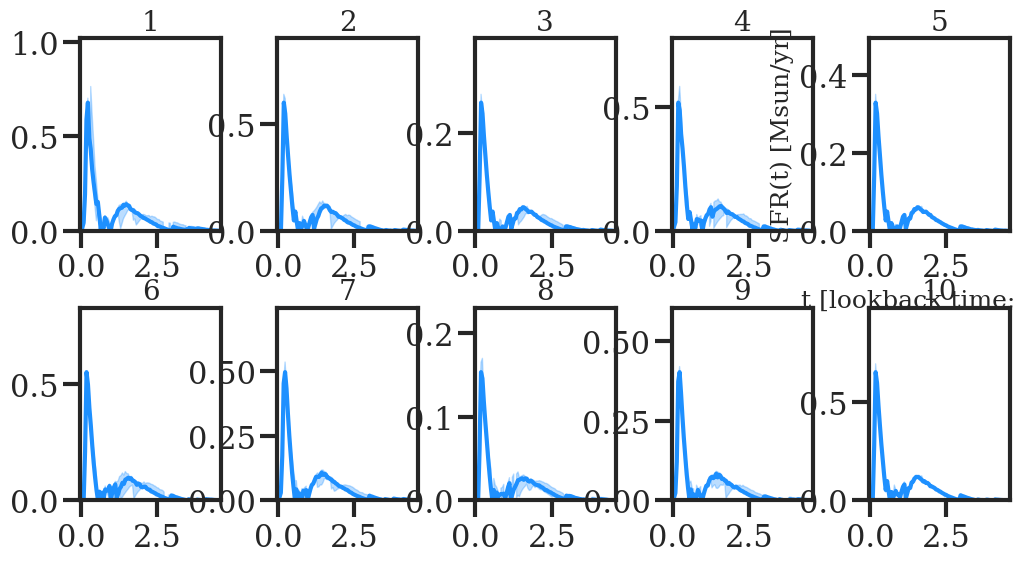

In [31]:
import matplotlib.pyplot as plt
font = {'family':'serif','size':8}
rc('font',**font)

f,axes=plt.subplots(2,5,figsize=(12,6))
axs = axes.ravel()

for i in range(len(tphot)):
    ax = axs[i]
    # ax.loglog(all_sedfits[i].lam_post/1e4,all_sedfits[i].spec_post_med,c='grey',lw=0.3)
    # ax.errorbar(lam_centers/1e4, all_sed[i],yerr=all_sederr[i],c='r',marker='o',linestyle='',ms=6)
    # ax.plot(lam_centers/1e4, all_bfsed[i],'o', markersize=5,mec='k',zorder=10,mfc='w')
    # ax.errorbar(lam_centers/1e4, all_bfsed[i], xerr = (lam_widths/2/1e4, lam_widths/2/1e4), lw=0,elinewidth=0.1,color='k',capsize=1)
    ax.plot(np.amax(all_timeax[i]) - all_timeax[i], all_sfh_50[i], c='dodgerblue',lw=3)
    ax.fill_between(np.amax(all_timeax[i]) - all_timeax[i], all_sfh_16[i],all_sfh_84[i], color='dodgerblue',alpha=0.3)
    #ax.axvline(all_t50s_sfh[i],color='k',lw=3,alpha=0.7)
    ax.set_xlim(-0.02, db.cosmo.age(zval).value)
    ax.set_title(i+1,fontsize=20)
    ax.set_ylim(0,np.nanmax(all_sfh_50[i])*1.5)
    
axs[-6].set_xlabel(r't [lookback time; Gyr]',fontsize=18)
axs[-6].set_ylabel(r'SFR(t) [Msun/yr]',fontsize=18)

f.subplots_adjust(wspace=0.4, hspace=0.4)

-11.316000000000441
-10.085000000000027
-10.075000000000024
-11.22500000000041
-10.073000000000023
-11.118000000000373
-11.34400000000045
-10.605000000000203
-11.34300000000045
-10.081000000000028


Text(0, 0.5, 'M$_{\\star}$ [M$_{\\odot}$]')

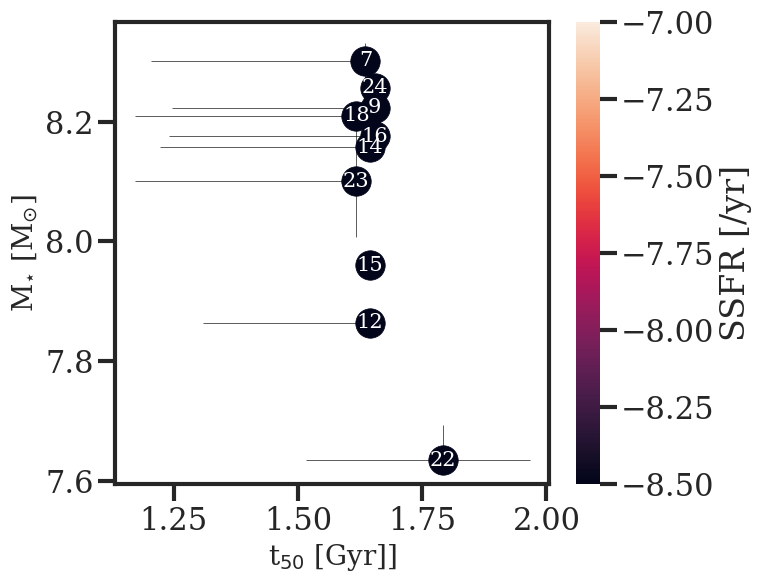

In [32]:
from astropy.cosmology import Planck18 as cosmo

f, ax = plt.subplots(1, 1, figsize=(7, 6))

for i in range(len(tphot)):
    x = all_masses[i][0]
    xerr1, xerr2 = x - all_masses[i][1], all_masses[i][2] - x
    xerr = ([xerr1], [xerr2])

    age_uni = cosmo.age(8.3).value
    t50 = all_t50s[i][0]
    ssfr = all_sfrs[i][0] - all_masses[i][0]
    print(ssfr)

    y = all_sfrs[i][0] - all_masses[i][0]
    yerr1, yerr2 = x + y - all_sfrs[i][1], all_sfrs[i][2] - x - y
    yerr = ([yerr1], [yerr2])

    y = all_t50s[i][0]
    yerr1, yerr2 = all_t50s[i][1] - y, y - all_t50s[i][2]
    yerr = ([yerr1], [yerr2])

    ax.errorbar(y, x, xerr=yerr, yerr=xerr, c="k", marker=" ", linestyle="", lw=0.5)
    cb = ax.scatter(
        y, x, c=ssfr, s=450, marker="o", lw=0.5, zorder=20, vmin=-8.5, vmax=-7
    )
    ax.text(
        y,
        x,
        spIDs[i],
        fontsize=15,
        c="w",
        zorder=100,
        verticalalignment="center",
        horizontalalignment="center",
    )

cbar = plt.colorbar(cb)
cbar.outline.set_visible(False)
cbar.set_label(r"SSFR [/yr]")

ax.set_xlabel(r"t$_{50}$ [Gyr]]", fontsize=20)
ax.set_ylabel(r"M$_{\star}$ [M$_{\odot}$]", fontsize=20)
# ax.set_ylim(-9.5,-7)
# ax.set_xlim(7.5,9.)